# IST 718 Group Project - Recordable Incidents and Near Misses in the Workplace
### Kim Greene, Brandon Croarkin, Amanda Sausville,  and Teng Siong (TS) Yeap

In [1]:
# import packages needed for analysis
import calendar
from matplotlib.pylab import plt
%matplotlib inline
import nltk
from nltk import FreqDist
from nltk.tokenize import RegexpTokenizer
import numpy as np
import pandas as pd  # data frame operations
from pandas import ExcelWriter
from pandas import ExcelFile
import pandasql as pdsql
import re
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn import metrics
import time
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

## Obtain 

In [2]:
#import dataset
incidentsDF = pd.read_excel('Incidents_and_NearMisses.xlsx', sheet_name='Sheet1')
incidentsDF.head()

,IncidentNo,IncidentType,CompanyName,Location,DateofOccurrence,YearofOccurrence,IncidentSummary,Area,IncidentDescription,InjuryDescripti,...,DaysonJobTransf,EmpIDCalc,InjustStatus,OccupationofInjured,OperationAtTimeofInjury,OSHARecordable,SBP,SOCCaption,SOCValue,MISS_PotentialImpact
0,130,Sprain,Company D,"Midland, TX",2013-04-21,2013,I.E. was pushing kelly hose off to the driller...,Rig Floor,I.E. was pushing kelly hose off to the driller...,contusions to those areas from slipping and st...,...,0,10711.0,First Aid,MOTOR_DRILLING,Rigging Down,0.0,Back (Lower),Texas,TX,NaN
1,131,Strain,Company D,"Rices Landing, PA",2013-04-05,2013,ee slipped on bottom step of stairs from mud t...,Stairs / Ladders,ee slipped on bottom step of stairs from mud t...,Strain to neck as a result of catching himself...,...,0,10713.0,First Aid,DERRICK_DRILLING,Well Control / BOP,0.0,Neck,West Virginia,WV,NaN
2,132,Strain,Company E,"Williston, ND",2013-04-18,2013,Ee was pulling back a stand of tubing while in...,Derrick / Mast,Ee was pulling back a stand of tubing while in...,Pain and stiffness in lower to middle right si...,...,0,21651.0,No Medical,DERRICK_WELL,Laying Down / Picking Up Pipe / Tubulars,0.0,Back (Lower),North Dakota,ND,NaN
3,136,Fracture,Company D,"Corpus Christi, TX",2013-04-04,2013,Ee's right ring fnger was caught between bushi...,Rig Floor,Ee's right ring fnger was caught between bushi...,Fracture of right ring finger as a result of f...,...,8,7025.0,Restricted Work Case,MOTOR_DRILLING,Making Connection,1.0,Finger,Texas,TX,NaN
4,138,Strain,Company E,"Williston, ND",2013-04-16,2013,Crew was rigging down the floor. Travis was li...,Rig Floor,Crew was rigging down the floor. Travis was li...,"Pain in upper back between shoulder blades, mo...",...,0,21065.0,First Aid,OPERATOR_WELL,Rigging Down,0.0,Back (Upper),North Dakota,ND,NaN


In [3]:
incidentsDF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3678 entries, 0 to 3677
Data columns (total 23 columns):
IncidentNo                 3678 non-null int64
IncidentType               3678 non-null object
CompanyName                3678 non-null object
Location                   3678 non-null object
DateofOccurrence           3678 non-null datetime64[ns]
YearofOccurrence           3678 non-null int64
IncidentSummary            3678 non-null object
Area                       3678 non-null object
IncidentDescription        3678 non-null object
InjuryDescripti            1951 non-null object
DateHiredCalc              1952 non-null datetime64[ns]
YearsatCompany             3678 non-null float64
DaysAwayFromWor            3678 non-null int64
DaysonJobTransf            3678 non-null int64
EmpIDCalc                  1952 non-null float64
InjustStatus               1952 non-null object
OccupationofInjured        1944 non-null object
OperationAtTimeofInjury    1952 non-null object
OSHARecordable 

## Scrub

In [4]:
#Drop IncidentNo, IncidentSummary, InjuryDescripti
incidentsDF = incidentsDF.drop(['IncidentNo', 'IncidentSummary','InjuryDescripti', 'SOCCaption', 'EmpIDCalc', 'MISS_PotentialImpact'], axis=1)
incidentsDF.head()

,IncidentType,CompanyName,Location,DateofOccurrence,YearofOccurrence,Area,IncidentDescription,DateHiredCalc,YearsatCompany,DaysAwayFromWor,DaysonJobTransf,InjustStatus,OccupationofInjured,OperationAtTimeofInjury,OSHARecordable,SBP,SOCValue
0,Sprain,Company D,"Midland, TX",2013-04-21,2013,Rig Floor,I.E. was pushing kelly hose off to the driller...,2011-04-20,7.90,0,0,First Aid,MOTOR_DRILLING,Rigging Down,0.0,Back (Lower),TX
1,Strain,Company D,"Rices Landing, PA",2013-04-05,2013,Stairs / Ladders,ee slipped on bottom step of stairs from mud t...,2011-09-14,7.49,0,0,First Aid,DERRICK_DRILLING,Well Control / BOP,0.0,Neck,WV
2,Strain,Company E,"Williston, ND",2013-04-18,2013,Derrick / Mast,Ee was pulling back a stand of tubing while in...,2012-10-09,6.42,0,0,No Medical,DERRICK_WELL,Laying Down / Picking Up Pipe / Tubulars,0.0,Back (Lower),ND
3,Fracture,Company D,"Corpus Christi, TX",2013-04-04,2013,Rig Floor,Ee's right ring fnger was caught between bushi...,2012-02-23,7.05,0,8,Restricted Work Case,MOTOR_DRILLING,Making Connection,1.0,Finger,TX
4,Strain,Company E,"Williston, ND",2013-04-16,2013,Rig Floor,Crew was rigging down the floor. Travis was li...,2011-10-31,7.36,0,0,First Aid,OPERATOR_WELL,Rigging Down,0.0,Back (Upper),ND


In [5]:
#make new columns for month of occurrence and day of week
incidentsDF['MonthOfOccurrence'] = [d.month for d in incidentsDF['DateofOccurrence']]
incidentsDF['WeekdayOfOccurrence'] = [d.weekday() for d in incidentsDF['DateofOccurrence']]
#convert integer month to string
incidentsDF['MonthOfOccurrence'] = [calendar.month_name[d] for d in incidentsDF['MonthOfOccurrence']]
#convert integer weekday to string
incidentsDF['WeekdayOfOccurrence'] = [calendar.day_name[d] for d in incidentsDF['WeekdayOfOccurrence']]
#can drop date of occurence now
incidentsDF = incidentsDF.drop(['DateofOccurrence'], axis = 1)
incidentsDF.head()

,IncidentType,CompanyName,Location,YearofOccurrence,Area,IncidentDescription,DateHiredCalc,YearsatCompany,DaysAwayFromWor,DaysonJobTransf,InjustStatus,OccupationofInjured,OperationAtTimeofInjury,OSHARecordable,SBP,SOCValue,MonthOfOccurrence,WeekdayOfOccurrence
0,Sprain,Company D,"Midland, TX",2013,Rig Floor,I.E. was pushing kelly hose off to the driller...,2011-04-20,7.90,0,0,First Aid,MOTOR_DRILLING,Rigging Down,0.0,Back (Lower),TX,April,Sunday
1,Strain,Company D,"Rices Landing, PA",2013,Stairs / Ladders,ee slipped on bottom step of stairs from mud t...,2011-09-14,7.49,0,0,First Aid,DERRICK_DRILLING,Well Control / BOP,0.0,Neck,WV,April,Friday
2,Strain,Company E,"Williston, ND",2013,Derrick / Mast,Ee was pulling back a stand of tubing while in...,2012-10-09,6.42,0,0,No Medical,DERRICK_WELL,Laying Down / Picking Up Pipe / Tubulars,0.0,Back (Lower),ND,April,Thursday
3,Fracture,Company D,"Corpus Christi, TX",2013,Rig Floor,Ee's right ring fnger was caught between bushi...,2012-02-23,7.05,0,8,Restricted Work Case,MOTOR_DRILLING,Making Connection,1.0,Finger,TX,April,Thursday
4,Strain,Company E,"Williston, ND",2013,Rig Floor,Crew was rigging down the floor. Travis was li...,2011-10-31,7.36,0,0,First Aid,OPERATOR_WELL,Rigging Down,0.0,Back (Upper),ND,April,Tuesday


In [6]:
incidentsDF.columns

Index(['IncidentType', 'CompanyName', 'Location', 'YearofOccurrence', 'Area',
       'IncidentDescription', 'DateHiredCalc', 'YearsatCompany',
       'DaysAwayFromWor', 'DaysonJobTransf', 'InjustStatus',
       'OccupationofInjured', 'OperationAtTimeofInjury', 'OSHARecordable',
       'SBP', 'SOCValue', 'MonthOfOccurrence', 'WeekdayOfOccurrence'],
      dtype='object')

In [7]:
#rename columns where needed
incidentsDF.columns = ['IncidentType', 'CompanyName', 'Location', 'YearOfOccurrence', 'Area',
       'IncidentDescription', 'DateHired', 'YearsatCompany',
       'DaysAwayFromWork', 'DaysOnJobTransf', 'InjuryStatus',
       'OccupationOfInjured', 'OperationAtTimeOfInjury', 'OSHARecordable',
       'SBP', 'SOCValue', 'MonthOfOccurrence', 'WeekdayOfOccurrence']

In [8]:
#separate Incident and near miss
nm = incidentsDF[incidentsDF['IncidentType'] == "Near Miss"]
nm.head()

,IncidentType,CompanyName,Location,YearOfOccurrence,Area,IncidentDescription,DateHired,YearsatCompany,DaysAwayFromWork,DaysOnJobTransf,InjuryStatus,OccupationOfInjured,OperationAtTimeOfInjury,OSHARecordable,SBP,SOCValue,MonthOfOccurrence,WeekdayOfOccurrence
95,Near Miss,Company F,"Billings, MT",2013,Inland Wellsite,Incident occured when crane operator scoped ou...,NaT,0.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,April,Friday
96,Near Miss,Company F,"Dickinson, ND",2013,Inland Wellsite,Employee removed lubricator from wellhead befo...,NaT,0.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,May,Thursday
98,Near Miss,Company F,"Williston, ND",2013,Inland Wellsite,While running power to the perforating trailer...,NaT,0.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,May,Saturday
100,Near Miss,Company F,"Dickinson, ND",2013,Inland Wellsite,When pressure testing our lubricator we had le...,NaT,0.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,May,Wednesday
125,Near Miss,Company E,"Conway, AR",2013,Other (Specify),"While rigging up Scanalog equipment, the opera...",NaT,0.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,November,Monday


In [9]:
inc = incidentsDF[incidentsDF['IncidentType'] != "Near Miss"]
inc.head()

,IncidentType,CompanyName,Location,YearOfOccurrence,Area,IncidentDescription,DateHired,YearsatCompany,DaysAwayFromWork,DaysOnJobTransf,InjuryStatus,OccupationOfInjured,OperationAtTimeOfInjury,OSHARecordable,SBP,SOCValue,MonthOfOccurrence,WeekdayOfOccurrence
0,Sprain,Company D,"Midland, TX",2013,Rig Floor,I.E. was pushing kelly hose off to the driller...,2011-04-20,7.90,0,0,First Aid,MOTOR_DRILLING,Rigging Down,0.0,Back (Lower),TX,April,Sunday
1,Strain,Company D,"Rices Landing, PA",2013,Stairs / Ladders,ee slipped on bottom step of stairs from mud t...,2011-09-14,7.49,0,0,First Aid,DERRICK_DRILLING,Well Control / BOP,0.0,Neck,WV,April,Friday
2,Strain,Company E,"Williston, ND",2013,Derrick / Mast,Ee was pulling back a stand of tubing while in...,2012-10-09,6.42,0,0,No Medical,DERRICK_WELL,Laying Down / Picking Up Pipe / Tubulars,0.0,Back (Lower),ND,April,Thursday
3,Fracture,Company D,"Corpus Christi, TX",2013,Rig Floor,Ee's right ring fnger was caught between bushi...,2012-02-23,7.05,0,8,Restricted Work Case,MOTOR_DRILLING,Making Connection,1.0,Finger,TX,April,Thursday
4,Strain,Company E,"Williston, ND",2013,Rig Floor,Crew was rigging down the floor. Travis was li...,2011-10-31,7.36,0,0,First Aid,OPERATOR_WELL,Rigging Down,0.0,Back (Upper),ND,April,Tuesday


In [10]:
#create a term document matrix without stemming

#make IncidentDescription become a list
doc = incidentsDF.IncidentDescription.tolist()
doc[:5]

# tokenize and remove unwanted elements from out data like symbols and numbers, 
#select 3 or more alphanumeric characters
token = RegexpTokenizer(r'[a-zA-Z]{3,}')

vec = CountVectorizer(lowercase=True,stop_words='english',ngram_range=(1,1),tokenizer=token.tokenize)
X = vec.fit_transform(doc)

tdm = pd.DataFrame(X.toarray(), columns=vec.get_feature_names())
print(tdm.shape)
tdm.head()

(3678, 5275)


,aaron,abdomen,abdominal,abel,able,abrasion,abrasions,abrupt,abruptly,abscess,...,yolk,zac,zack,zep,zero,zeroes,zinc,zip,zipper,zone
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


There are a lot of meaningless words. Let filter out the columns that have less than 3 characters

In [11]:
#merge incidentsDF and tdm
frames = [incidentsDF, tdm]
df_merged = pd.concat(frames, axis = 1)
#removing uneeded fields or injury description fields that would give away whether it is near miss or injury
#YearsatCompany removed since it is not collected for NearMisses
df_merged.drop(['InjuryStatus', 'SOCValue','OSHARecordable', 'SBP', 'YearsatCompany','IncidentDescription', 'OccupationOfInjured', 'OperationAtTimeOfInjury','DaysAwayFromWork', 'DateHired'], axis  = 1, inplace = True)
df_merged.head()

,IncidentType,CompanyName,Location,YearOfOccurrence,Area,DaysOnJobTransf,MonthOfOccurrence,WeekdayOfOccurrence,aaron,abdomen,...,yolk,zac,zack,zep,zero,zeroes,zinc,zip,zipper,zone
0,Sprain,Company D,"Midland, TX",2013,Rig Floor,0,April,Sunday,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Strain,Company D,"Rices Landing, PA",2013,Stairs / Ladders,0,April,Friday,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Strain,Company E,"Williston, ND",2013,Derrick / Mast,0,April,Thursday,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Fracture,Company D,"Corpus Christi, TX",2013,Rig Floor,8,April,Thursday,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Strain,Company E,"Williston, ND",2013,Rig Floor,0,April,Tuesday,0,0,...,0,0,0,0,0,0,0,0,0,0


In [12]:
#change datatypes to factor where needed
df_merged['CompanyName'] = df_merged['CompanyName'].astype('category')
df_merged['Location'] = df_merged['Location'].astype('category')
df_merged['Area'] = df_merged['Area'].astype('category')
df_merged['MonthOfOccurrence'] = df_merged['MonthOfOccurrence'].astype('category')
df_merged['WeekdayOfOccurrence'] = df_merged['WeekdayOfOccurrence'].astype('category')

In [13]:
#create a new column named "Label". If the IncidentType is NOT "Near Miss", change it to "Incident"
df_merged['Label'] = df_merged['IncidentType']
df_merged['Label'] = ['Near Miss' if x == 'Near Miss' else 'Incident' for x in df_merged['Label']]
#now drop incident type after making the label column
df_merged = df_merged.drop(['IncidentType'], axis = 1)
df_merged.head()

,CompanyName,Location,YearOfOccurrence,Area,DaysOnJobTransf,MonthOfOccurrence,WeekdayOfOccurrence,aaron,abdomen,abdominal,...,zac,zack,zep,zero,zeroes,zinc,zip,zipper,zone,Label
0,Company D,"Midland, TX",2013,Rig Floor,0,April,Sunday,0,0,0,...,0,0,0,0,0,0,0,0,0,Incident
1,Company D,"Rices Landing, PA",2013,Stairs / Ladders,0,April,Friday,0,0,0,...,0,0,0,0,0,0,0,0,0,Incident
2,Company E,"Williston, ND",2013,Derrick / Mast,0,April,Thursday,0,0,0,...,0,0,0,0,0,0,0,0,0,Incident
3,Company D,"Corpus Christi, TX",2013,Rig Floor,8,April,Thursday,0,0,0,...,0,0,0,0,0,0,0,0,0,Incident
4,Company E,"Williston, ND",2013,Rig Floor,0,April,Tuesday,0,0,0,...,0,0,0,0,0,0,0,0,0,Incident


In [14]:
#create a dataset with one hot encoding
df_merged_onehot = pd.get_dummies(df_merged.iloc[:,:-1])
print(df_merged_onehot.shape)
df_merged_onehot.head()

(3678, 5479)


,YearOfOccurrence,DaysOnJobTransf,aaron,abdomen,abdominal,abel,able,abrasion,abrasions,abrupt,...,MonthOfOccurrence_November,MonthOfOccurrence_October,MonthOfOccurrence_September,WeekdayOfOccurrence_Friday,WeekdayOfOccurrence_Monday,WeekdayOfOccurrence_Saturday,WeekdayOfOccurrence_Sunday,WeekdayOfOccurrence_Thursday,WeekdayOfOccurrence_Tuesday,WeekdayOfOccurrence_Wednesday
0,2013,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
1,2013,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
2,2013,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,2013,8,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4,2013,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


## Explore 

Is there any trend in injuries vs. near-misses by day of the week?

In [15]:
#select needed columns
wd_injuries = df_merged[['WeekdayOfOccurrence','Label']]
#groupby weekday and label, then count labels
wd_injuries = pd.DataFrame(wd_injuries.groupby(['WeekdayOfOccurrence','Label'])['Label'].count())
#rename columns
wd_injuries.columns = ['Count']
#reset indices to make them columns
wd_injuries.reset_index(inplace = True)
#convert weekday to number to sort
wd_injuries['Weekday'] = [time.strptime(x, '%A').tm_wday for x in wd_injuries['WeekdayOfOccurrence']]
#sort on Weekday column
wd_injuries = wd_injuries.sort_values(by = 'Weekday')
#reset indices
wd_injuries.reset_index(inplace = True, drop = True)
#view final dataframe
wd_injuries

,WeekdayOfOccurrence,Label,Count,Weekday
0,Monday,Incident,341,0
1,Monday,Near Miss,266,0
2,Tuesday,Incident,322,1
3,Tuesday,Near Miss,263,1
4,Wednesday,Incident,328,2
5,Wednesday,Near Miss,237,2
6,Thursday,Incident,316,3
7,Thursday,Near Miss,243,3
8,Friday,Incident,254,4
9,Friday,Near Miss,230,4


(array([  0.,  50., 100., 150., 200., 250., 300., 350., 400.]),
 <a list of 9 Text yticklabel objects>)

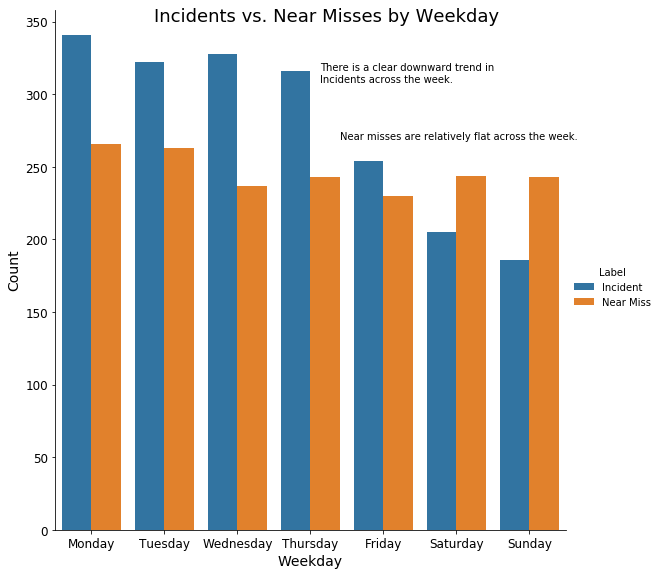

In [16]:
w = sns.catplot(x = 'WeekdayOfOccurrence', y = 'Count', hue = 'Label', data = wd_injuries, height = 8, kind = 'bar', 
                order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
w.fig.suptitle('Incidents vs. Near Misses by Weekday', fontsize = 18)
w.fig.text(.49,0.85, "There is a clear downward trend in \nIncidents across the week.")
w.fig.text(.52,0.75, "Near misses are relatively flat across the week.")

plt.xlabel('Weekday', fontsize = 14)
plt.xticks(fontsize = 12)
plt.ylabel('Count', fontsize = 14)
plt.yticks(fontsize = 12)

Is there any trend in incidents vs. near-misses by month?

In [17]:
#select needed columns
m_injuries = df_merged[['MonthOfOccurrence','Label']]
#groupby weekday and label, then count labels
m_injuries = pd.DataFrame(m_injuries.groupby(['MonthOfOccurrence','Label'])['Label'].count())
#rename columns
m_injuries.columns = ['Count']
#reset indices to make them columns
m_injuries.reset_index(inplace = True)
#convert weekday to number to sort
m_injuries['Month'] = [time.strptime(x, '%B').tm_mon for x in m_injuries['MonthOfOccurrence']]
#sort on Weekday column
m_injuries = m_injuries.sort_values(by = 'Month')
#reset indices
m_injuries.reset_index(inplace = True, drop = True)
#view final dataframe
m_injuries

,MonthOfOccurrence,Label,Count,Month
0,January,Incident,195,1
1,January,Near Miss,115,1
2,February,Incident,141,2
3,February,Near Miss,98,2
4,March,Near Miss,135,3
5,March,Incident,139,3
6,April,Incident,133,4
7,April,Near Miss,126,4
8,May,Near Miss,119,5
9,May,Incident,149,5


Text(0.45, 0.77, 'The summer months tend to have \nthe most incidents.')

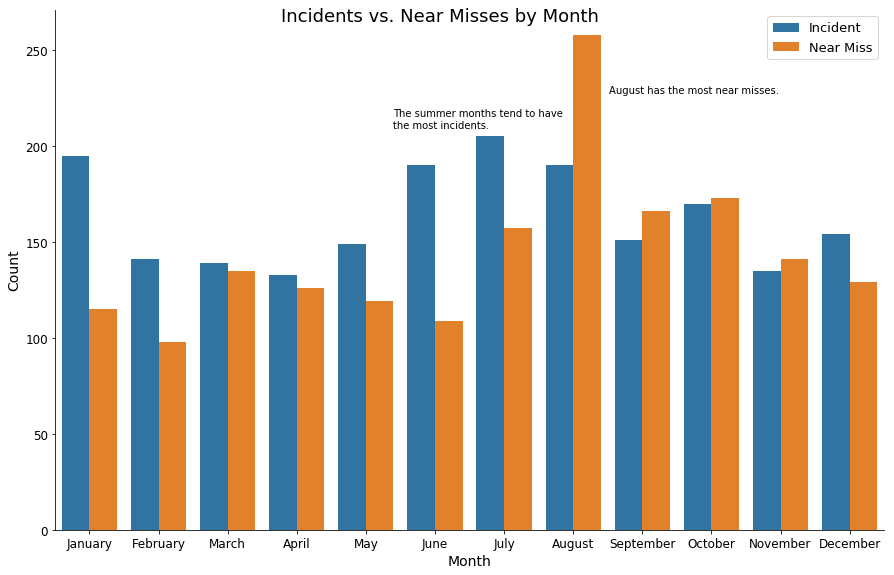

In [18]:
m = sns.catplot(x = 'MonthOfOccurrence', y = 'Count', hue = 'Label', data = m_injuries, height = 8, kind = 'bar', legend = False,
                order = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December'])
m.fig.suptitle('Incidents vs. Near Misses by Month', fontsize = 18)
m.fig.set_size_inches(13,8)

plt.xlabel('Month', fontsize = 14)
plt.xticks(fontsize = 12)
plt.ylabel('Count', fontsize = 14)
plt.yticks(fontsize = 12)
plt.legend(loc='upper right', fontsize= 13)

m.fig.text(.68,0.83, "August has the most near misses.")
m.fig.text(.45,0.77, "The summer months tend to have \nthe most incidents.")

What companies have the most incidents and near-misses?

In [19]:
# I want to view Near Misses vs. Incidents for each company
nmvi = df_merged[['Label', 'CompanyName']]
nmvi = nmvi.groupby(['CompanyName','Label'])['Label'].count()
nmvi = pd.DataFrame(nmvi)
nmvi.columns = ['Count']
nmvi.reset_index(inplace = True)
nmvi
#df_merged['Label'].value_counts()
#sns.factorplot(x = 'CompanyName', y =)

,CompanyName,Label,Count
0,Company A,Incident,9
1,Company B,Incident,16
2,Company C,Incident,87
3,Company C,Near Miss,43
4,Company D,Incident,613
5,Company D,Near Miss,1287
6,Company E,Incident,758
7,Company E,Near Miss,107
8,Company F,Incident,469
9,Company F,Near Miss,289


C:\Users\HP\Anaconda3\lib\site-packages\seaborn\categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
C:\Users\HP\Anaconda3\lib\site-packages\seaborn\categorical.py:3672: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


Text(0.21, 0.4, 'Company D has more total \nincidents than any other company.')

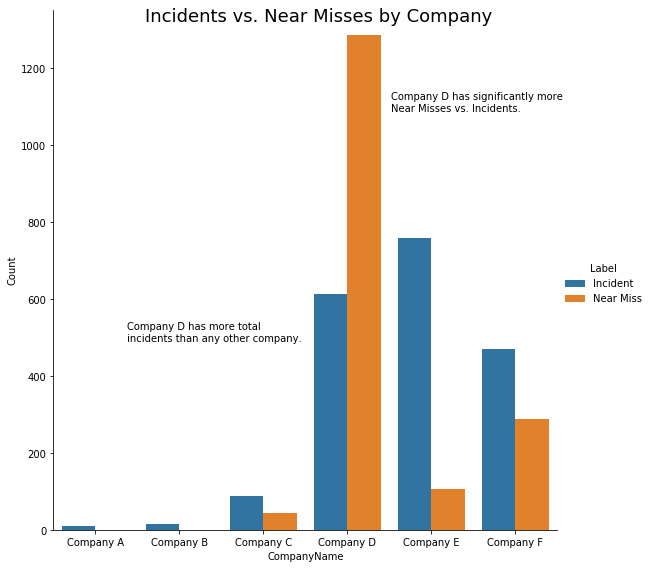

In [20]:
g = sns.factorplot(x = 'CompanyName', y = 'Count', hue = 'Label', data = nmvi, size = 8, kind = 'bar')
g.fig.suptitle('Incidents vs. Near Misses by Company', fontsize = 18)
g.fig.text(.61,0.8, "Company D has significantly more \nNear Misses vs. Incidents.")
g.fig.text(.21,0.4, "Company D has more total \nincidents than any other company.")

Where do most injuries occur?

In [21]:
ivc = pd.DataFrame(incidentsDF['Area'].value_counts())
ivc = ivc.reset_index().head(20)
ivc

,index,Area
0,Rig Floor,1117
1,Inland Wellsite,484
2,Rig Pad / Decks / Well Site / Yard,247
3,Shop,219
4,Other (Specify),202
5,Derrick / Mast,170
6,Cellar / Substructure,161
7,Catwalk / V-Door Slide,138
8,Rig Pad,129
9,Mud Pits / Tanks,83


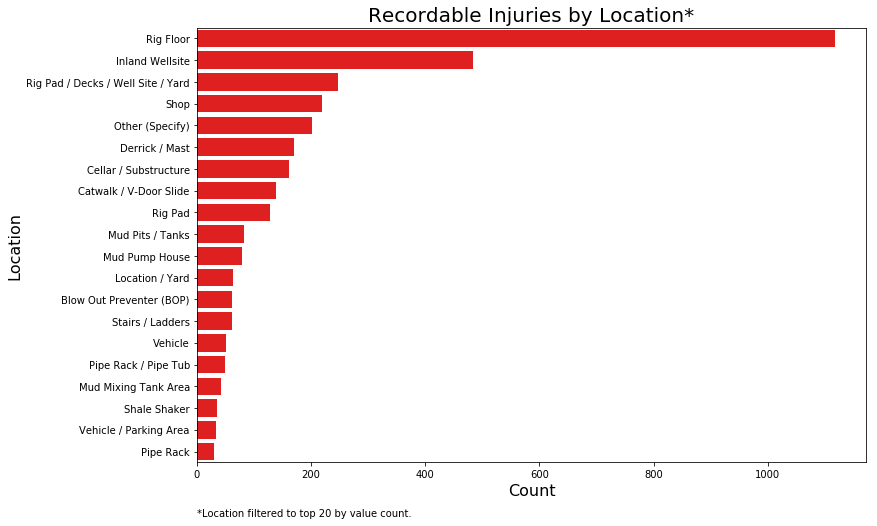

In [22]:
plt.figure(figsize=(12,8))
# plot barh chart with index as x values
fig = sns.barplot(ivc['Area'], ivc['index'], color = "red")
plt.xlabel("Count", fontsize = 16)
plt.ylabel("Location", fontsize = 16)
plt.title('Recordable Injuries by Location*', fontsize=20)
plt.text(1,22,'*Location filtered to top 20 by value count.')
plt.show()

What is the average years at the company for injured employees?

C:\Users\HP\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


<Figure size 432x288 with 0 Axes>

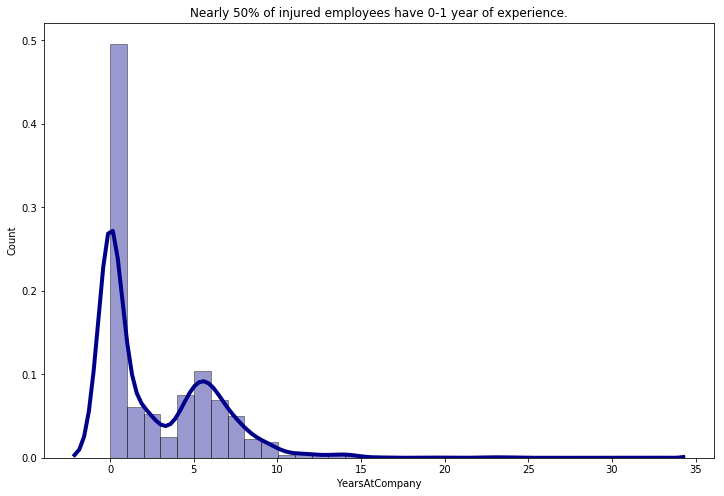

In [23]:
binwidth = 2
YearsAtCompany = incidentsDF['YearsatCompany']
fig = plt.figure()
plt.figure(figsize=(12,8))
sns.distplot(YearsAtCompany, hist = True, kde = True, color = 'darkblue', bins = 32, hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4})
plt.xlabel('YearsAtCompany')
plt.ylabel('Count')
plt.title('Nearly 50% of injured employees have 0-1 year of experience.')
plt.show()

What are the most common injuries sustained by employees?

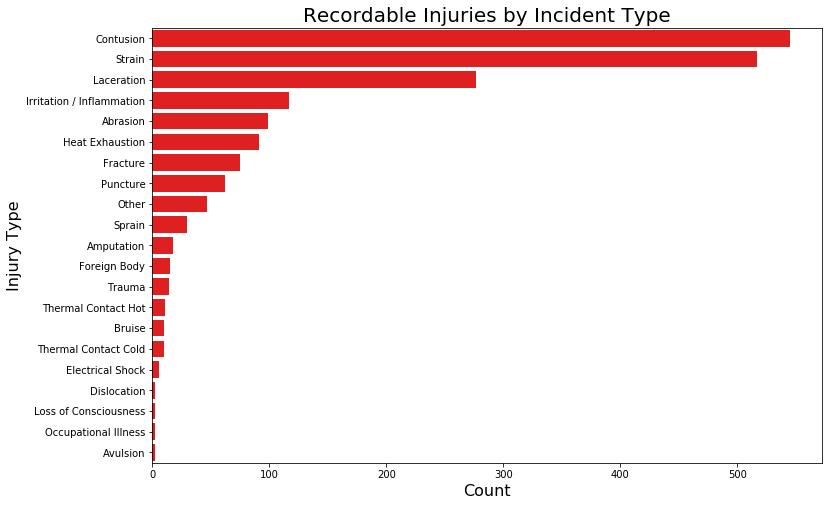

In [24]:
pysql = lambda q: pdsql.sqldf(q, globals())

# Create bar plot showing injuries by Incident Type
q = """SELECT IncidentType, Count(*) [Recordable Injuries] from incidentsDF where IncidentType <> 'Near Miss' group by IncidentType;"""
inctypeDF = pysql(q)

x = inctypeDF['IncidentType']
y= inctypeDF['Recordable Injuries']

#sort x and y in descending order
z = pd.DataFrame(sorted(zip(x,y)))
z.sort_values(by = 1, ascending=False, inplace = True)
z = z.reset_index(drop = True)
x = pd.Series(z[0])
y = pd.Series(z[1])

plt.figure(figsize=(12,8))
# plot barh chart with index as x values
fig = sns.barplot(z[1], z[0], color = "red")
plt.xlabel("Count", fontsize = 16)
plt.ylabel("Injury Type", fontsize = 16)
plt.title('Recordable Injuries by Incident Type', fontsize=20)
plt.show()

Are there any trends in injuries over time?

In [25]:
#create dataframe showing injury trend by company

q = """SELECT distinct YearOfOccurrence from incidentsDF order by YearofOccurrence;"""
yearsdf = pysql(q)

q = """SELECT CompanyName, count(*) [InjuryCount], YearOfOccurrence from incidentsDF  group by CompanyName, YearofOccurrence order by YearofOccurrence;"""
trend1df = pysql(q)

q = """SELECT a.YearofOccurrence, CASE WHEN b.CompanyName='Company A' THEN InjuryCount Else 0 END [CompanyA] ,
        CASE WHEN b.CompanyName='Company B' THEN InjuryCount Else 0 END [CompanyB],
        CASE WHEN b.CompanyName='Company C' THEN InjuryCount Else 0 END [CompanyC],
        CASE WHEN b.CompanyName='Company D' THEN InjuryCount Else 0 END [CompanyD],
        CASE WHEN b.CompanyName='Company E' THEN InjuryCount Else 0 END [CompanyE],
        CASE WHEN b.CompanyName='Company F' THEN InjuryCount Else 0 END [CompanyF]
        FROM yearsdf a left join trend1df b on a.YearofOccurrence=b.YearofOccurrence;"""
trend2df = pysql(q)

q="""SELECT YearofOccurrence, SUM(CompanyA) [CompanyA], SUM(CompanyB) [CompanyB], SUM(CompanyC) [CompanyC],
        SUM(CompanyD) [CompanyD], SUM(CompanyE) [CompanyE], SUM(CompanyF) [CompanyF] from trend2df GROUP BY YearofOccurrence;"""
Trenddf = pysql(q)

#drop 2019 as it's not a complete year
Trenddf = Trenddf.drop(Trenddf[Trenddf.YearOfOccurrence == 2019].index)
Trenddf

,YearOfOccurrence,CompanyA,CompanyB,CompanyC,CompanyD,CompanyE,CompanyF
0,2013,6,6,23,443,151,71
1,2014,2,3,26,690,264,121
2,2015,0,2,27,215,138,70
3,2016,1,1,20,250,88,129
4,2017,0,3,17,140,90,156
5,2018,0,1,15,139,124,196


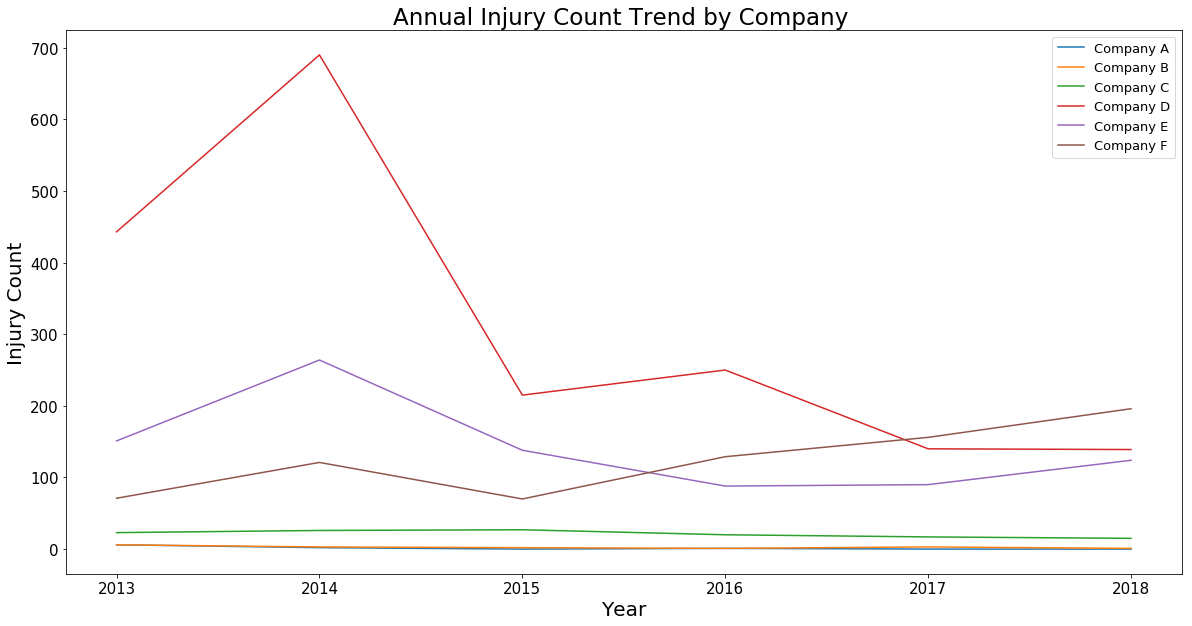

In [26]:
x = Trenddf['YearOfOccurrence']
Y1 = Trenddf['CompanyA']
Y2 = Trenddf['CompanyB']
Y3 = Trenddf['CompanyC']
Y4 = Trenddf['CompanyD']
Y5 = Trenddf['CompanyE']
Y6 = Trenddf['CompanyF']

plt.figure(figsize=(20,10))
plt.plot(x,Y1, label='Company A')
plt.plot(x,Y2, label='Company B')
plt.plot(x,Y3, label='Company C')
plt.plot(x,Y4, label='Company D')
plt.plot(x,Y5, label='Company E')
plt.plot(x,Y6, label='Company F')

plt.legend(loc='upper right', fontsize= 13)
plt.title('Annual Injury Count Trend by Company ', fontsize=23)
plt.xlabel('Year', fontsize=20)
plt.ylabel('Injury Count', fontsize=20)
plt.xticks(size = 15)
plt.yticks(size = 15)
plt.show()

In [27]:
#find total incidents by year
col_list = list(Trenddf.columns)[1:]
Trenddf['YearTotal'] = Trenddf[col_list].sum(axis = 1)
Trenddf

,YearOfOccurrence,CompanyA,CompanyB,CompanyC,CompanyD,CompanyE,CompanyF,YearTotal
0,2013,6,6,23,443,151,71,700
1,2014,2,3,26,690,264,121,1106
2,2015,0,2,27,215,138,70,452
3,2016,1,1,20,250,88,129,489
4,2017,0,3,17,140,90,156,406
5,2018,0,1,15,139,124,196,475


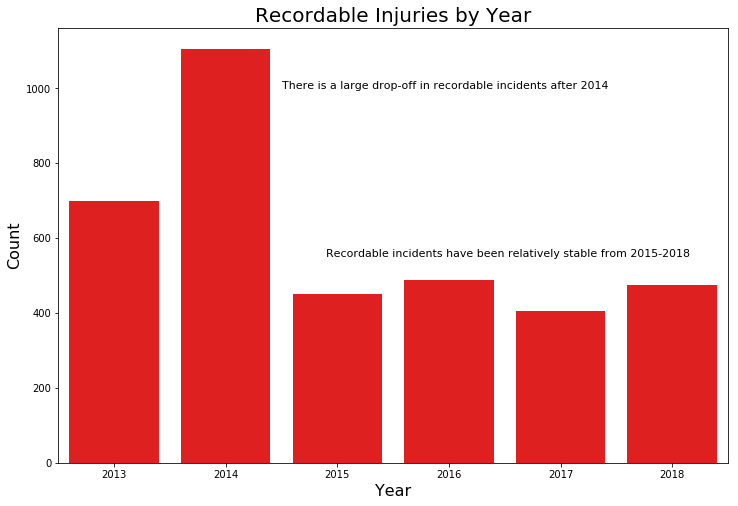

In [28]:
plt.figure(figsize=(12,8))
# plot barh chart with index as x values
fig = sns.barplot(Trenddf['YearOfOccurrence'], Trenddf['YearTotal'], color = "r")
fig.text(1.5, 1000, "There is a large drop-off in recordable incidents after 2014", fontsize = 11)
fig.text(1.9, 550, "Recordable incidents have been relatively stable from 2015-2018", fontsize = 11)
plt.xlabel("Year", fontsize = 16)
plt.ylabel("Count", fontsize = 16)
plt.title('Recordable Injuries by Year', fontsize=20)
plt.show()

In [30]:
#this function will take a column variable, concatenate all the injury descriptions, apply stop words
#and generate a word cloud
def myCloud (description):
    text = " ".join(desc for desc in description)
    print ("There are {} words in the combination of all description.".format(len(text)))
    
    # Create stopword list:
    stopwords = set(STOPWORDS)
    stopwords.update(["employee","EE","IE"])
    
    # Generate a word cloud image
    wordcloud = WordCloud(stopwords=stopwords,  max_words=50, background_color="white").generate(text)
    
    # Display the generated image:
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()

Word cloud for Near Misses
There are 324238 words in the combination of all description.


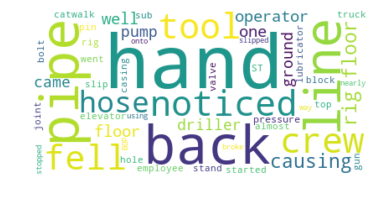

Word cloud for Incidents
There are 511929 words in the combination of all description.


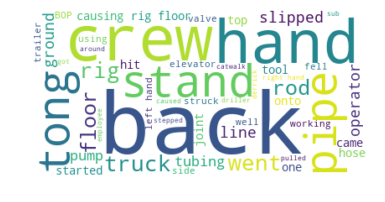

In [31]:
#word cloud for Near Miss
print('\033[1m' + 'Word cloud for Near Misses')
myCloud(nm.IncidentDescription)

#word cloud for Incident
print('\033[1m' + 'Word cloud for Incidents')
myCloud(inc.IncidentDescription)

Wodcloud just shows the common words in the corpus.
So, what are the top 10 words for Near Miss and Incident?

In [32]:
# function that takes a word and returns true if it consists only
#   of non-alphabetic characters  (assumes import re)
def alpha_filter(w):
  # pattern to match word of non-alphabetical characters
  pattern = re.compile('^[^a-z]+$')
  if (pattern.match(w)):
    return True
  else:
    return False

In [33]:
#create a function that will take a column variable, concatenate all the injury descriptions, apply stop words
#and crate a word distribution
def myDist (description):
    text = " ".join(desc for desc in description)
    
    #tokenize
    tokens = nltk.word_tokenize(text)
    
    #lower the words
    words = [w.lower( ) for w in tokens] 
    
    #apply alpha filter
    alphawords = [w for w in words if not alpha_filter(w)]
    
    #Create stopword list:
    stopwords = set(STOPWORDS)
    stopwords.update(["employee","ee","ie"])
    
    #make a frequency distribution after applying stopwords
    dist = FreqDist([w for w in alphawords if not w in stopwords])
    items = dist.most_common(10)
    for item in items:
        print(item)

In [34]:
#Frequency distribution for Near Miss
print('\033[1m' + 'Frequency Distribution for Near Misses')
myDist(nm.IncidentDescription)
print("\n")
#Frequency Distribution for Incident
print('\033[1m' + 'Frequency Distribution for Incidents')
myDist(inc.IncidentDescription)

Frequency Distribution for Near Misses
('hand', 679)
('pipe', 463)
('floor', 356)
('line', 308)
('rig', 299)
('almost', 291)
('fell', 253)
('crew', 239)
('back', 223)
('nearly', 216)


Frequency Distribution for Incidents
('left', 726)
('right', 722)
('back', 679)
('pipe', 616)
('hand', 581)
('rig', 460)
('crew', 417)
('floor', 414)
("'s", 412)
('slipped', 336)


## Model 

### Random Forest Classifer - combined TDM and Incident dataframe

In [35]:
# Separate the labels that we are trying to predict
labels = np.array(df_merged['Label'])

# Factorize the labels (Incidents are 0 and Near Misses are 1)
labels = pd.factorize(labels)[0]

# Save feature names for later use
feature_list = list(df_merged_onehot.columns)

# Convert to numpy array
features = np.array(df_merged_onehot)

In [36]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size = 0.2, random_state = 42)

In [37]:
incidents, near_misses = np.unique(labels, return_counts = True)[1]
total_incidents = incidents + near_misses
print(f"Near miss occur {round(near_misses/total_incidents, 2)}% of the time")
print(f"Actual incidents occur {round(incidents/total_incidents, 2)}% of the time")

Near miss occur 0.47% of the time
Actual incidents occur 0.53% of the time


In [38]:
#Create a Gaussian Classifier
clf=RandomForestClassifier(n_estimators=100)

#Train the model using the training sets y_pred=clf.predict(X_test)
clf.fit(X_train,y_train)

y_pred=clf.predict(X_test)

In [39]:
# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.9619565217391305


In [40]:
# View the predicted probabilities of the first 10 observations
print("Predicted label probabilities \n",clf.predict_proba(X_train)[0:10])
# View the actual labels to compare
print("Actual labels \n", y_train[0:10])

Predicted label probabilities 
 [[0.   1.  ]
 [0.15 0.85]
 [0.12 0.88]
 [0.03 0.97]
 [0.96 0.04]
 [0.96 0.04]
 [0.98 0.02]
 [0.96 0.04]
 [0.67 0.33]
 [0.12 0.88]]
Actual labels 
 [1 1 1 1 0 0 0 0 0 1]


In [41]:
importances = clf.feature_importances_
indices = np.argsort(importances)
len(indices)

5479

ValueError: shape mismatch: objects cannot be broadcast to a single shape

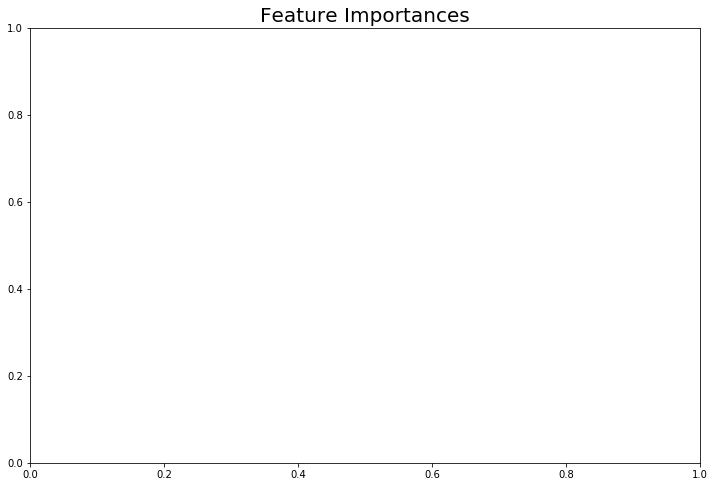

In [42]:
importances = clf.feature_importances_
indices = np.argsort(importances)[5818:]

plt.figure(figsize=(12,8))
plt.title('Feature Importances', fontsize = 20)
plt.barh(range(20), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [feature_list[i] for i in indices], fontsize = 14)
plt.xticks(fontsize = 12)
plt.xlabel('Relative Importance', fontsize = 14)
plt.show()

### Naive Bayes - combined TDM and Incident dataframe

Sci-Kit Learn Naive Bayes

In [ ]:
#Create a Gaussian Classifier
gnb = GaussianNB()

# Train the model using the training sets 
gnb.fit(X_train, y_train)

y_pred = gnb.predict(X_test)

In [ ]:
# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Given the injury description term document matrix and other included variables, we are able to get a get a good prediction with the Random Forest model of 96.5%. The Naive Bayes model did not perform as well, getting only a prediction accuracy of 81.1%. 

### Random Forest - incident dataframe

In [ ]:
c = df_merged_onehot.iloc[:,:2]
d = df_merged_onehot.iloc[:,5637:]
incidentsDF_onehot = pd.concat([c,d], axis = 1)
incidentsDF_onehot.head()

In [ ]:
# Separate the labels that we are trying to predict
labels = np.array(df_merged['Label'])

# Factorize the labels (Incidents are 0 and Near Misses are 1)
labels = pd.factorize(labels)[0]

# Save feature names for later use
feature_list = list(incidentsDF_onehot.columns)

# Convert to numpy array
features = np.array(incidentsDF_onehot)

In [ ]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size = 0.2, random_state = 42)

In [ ]:
#Create a Gaussian Classifier
clf=RandomForestClassifier(n_estimators=100)

#Train the model using the training sets y_pred=clf.predict(X_test)
clf.fit(X_train,y_train)

y_pred=clf.predict(X_test)

In [ ]:
# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

In [ ]:
# View the predicted probabilities of the first 10 observations
print("Predicted label probabilities \n",clf.predict_proba(X_train)[0:10])
# View the actual labels to compare
print("Actual labels \n", y_train[0:10])

In [ ]:
importances = clf.feature_importances_
indices = np.argsort(importances)[183:]

plt.figure(figsize=(12,8))
plt.title('Feature Importances')
plt.barh(range(20), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [feature_list[i] for i in indices], fontsize = 14)
plt.xlabel('Relative Importance', fontsize = 14)
plt.show()

### Random Forest - TDM

In [ ]:
# Separate the labels that we are trying to predict
labels = np.array(df_merged['Label'])

# Factorize the labels (Incidents are 0 and Near Misses are 1)
labels = pd.factorize(labels)[0]

# Save feature names for later use
feature_list = list(tdm.columns)

# Convert to numpy array
features = np.array(tdm)

In [ ]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size = 0.2, random_state = 42)

In [ ]:
#Create a Gaussian Classifier
clf=RandomForestClassifier(n_estimators=100)

#Train the model using the training sets y_pred=clf.predict(X_test)
clf.fit(X_train,y_train)

y_pred=clf.predict(X_test)

In [ ]:
# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

### Naive Bayes - TDM

In [ ]:
#Create a Gaussian Classifier
gnb = GaussianNB()

# Train the model using the training sets 
gnb.fit(X_train, y_train)

y_pred = gnb.predict(X_test)

In [ ]:
# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))